In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class Autoencoder(nn.Module):
  def __init__(self, lat_dim):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential( 
                      nn.Linear(784, 512),        
                      nn.ReLU(),
                      nn.Linear(512, 128),
                      nn.ReLU(),
                      nn.Linear(128, lat_dim),
                  )

    self.decoder = nn.Sequential( 
                      nn.Linear(lat_dim, 128), 
                      nn.ReLU(),
                      nn.Linear(128, 512),   
                      nn.ReLU(), 
                      nn.Linear(512, 784),     
                      nn.Sigmoid()
                  )

  def forward(self, x):
    z = self.encoder(x)
    z = self.decoder(z)
    return z  

In [3]:
class Encoder(nn.Module):
    def __init__(self, lat_dim):
        super().__init__()
        
        self.lat_dim = lat_dim
        
        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 512), 
            nn.ReLU(),
            nn.Linear(512, 128), 
            nn.ReLU(),
            nn.Linear(128, self.lat_dim)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z


class Decoder(nn.Module):
    def __init__(self, lat_dim):
        super().__init__()
        
        self.lat_dim = lat_dim
        
        # YOUR CODE HERE
        self.decoder = nn.Sequential(
            nn.Linear(self.lat_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 512), 
            nn.ReLU(),
            nn.Linear(512, 784), 
            nn.Sigmoid()
        )
        
    def forward(self, z):
        x = self.decoder(z)
        x = x.view(-1, 1, 28, 28)
        
        return x

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, lat_dim, encoder=Encoder,decoder=Decoder):
        super().__init__()
        
        self.lat_dim = lat_dim
        self.enc = encoder(lat_dim)
        self.dec = decoder(lat_dim)
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)

In [5]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

In [6]:
mnist_train = dset.MNIST(
    "./", train=True, transform=transforms.ToTensor(), 
    target_transform=None, download=True)
mnist_test = dset.MNIST(
    "./", train=False, transform=transforms.ToTensor(),
    target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(
    mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(
    mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)


In [7]:
def train(model,train_loader,loss_func,optimizer,num_epoch,device):

  loss_arr = []
  for i in range(num_epoch):
      for j , [image, label] in enumerate (train_loader):
          x = image.to(device)
          
          optimizer.zero_grad()
          z = model.encode(x)
          output = model.decode(z) 
          loss = loss_func(output, x)
          # loss_arr.append(loss.cpu().detach().numpy())

          loss.backward()
          optimizer.step()
      loss_arr.append(loss.cpu().detach().numpy())
  # out_img = torch.squeeze(output.cpu().data)
  # for i in range(6):
  #   plt.subplot(1,2,1)
  #   plt.imshow(torch.squeeze(image[i]).numpy(), cmap = 'gray')
  #   plt.subplot(1,2,2)
  #   plt.imshow(out_img[i].numpy(), cmap='gray')
  #   plt.show()
  return loss_arr

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
lat_dim = 10
model = Autoencoder(lat_dim).to(device)
loss_func = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters())

cuda:0


In [9]:
loss = train(model,train_loader, loss_func, optimizer,10,device)

In [ ]:
loss_dict = {}
lat_arr =['5','10','20']
for i in lat_arr:
  model = Autoencoder(int(i)).to(device)
  loss_func = nn.MSELoss()
  optimizer  = torch.optim.Adam(model.parameters())
  loss = train(model,train_loader,loss_func, optimizer,10,device)
  loss_dict[i] = loss

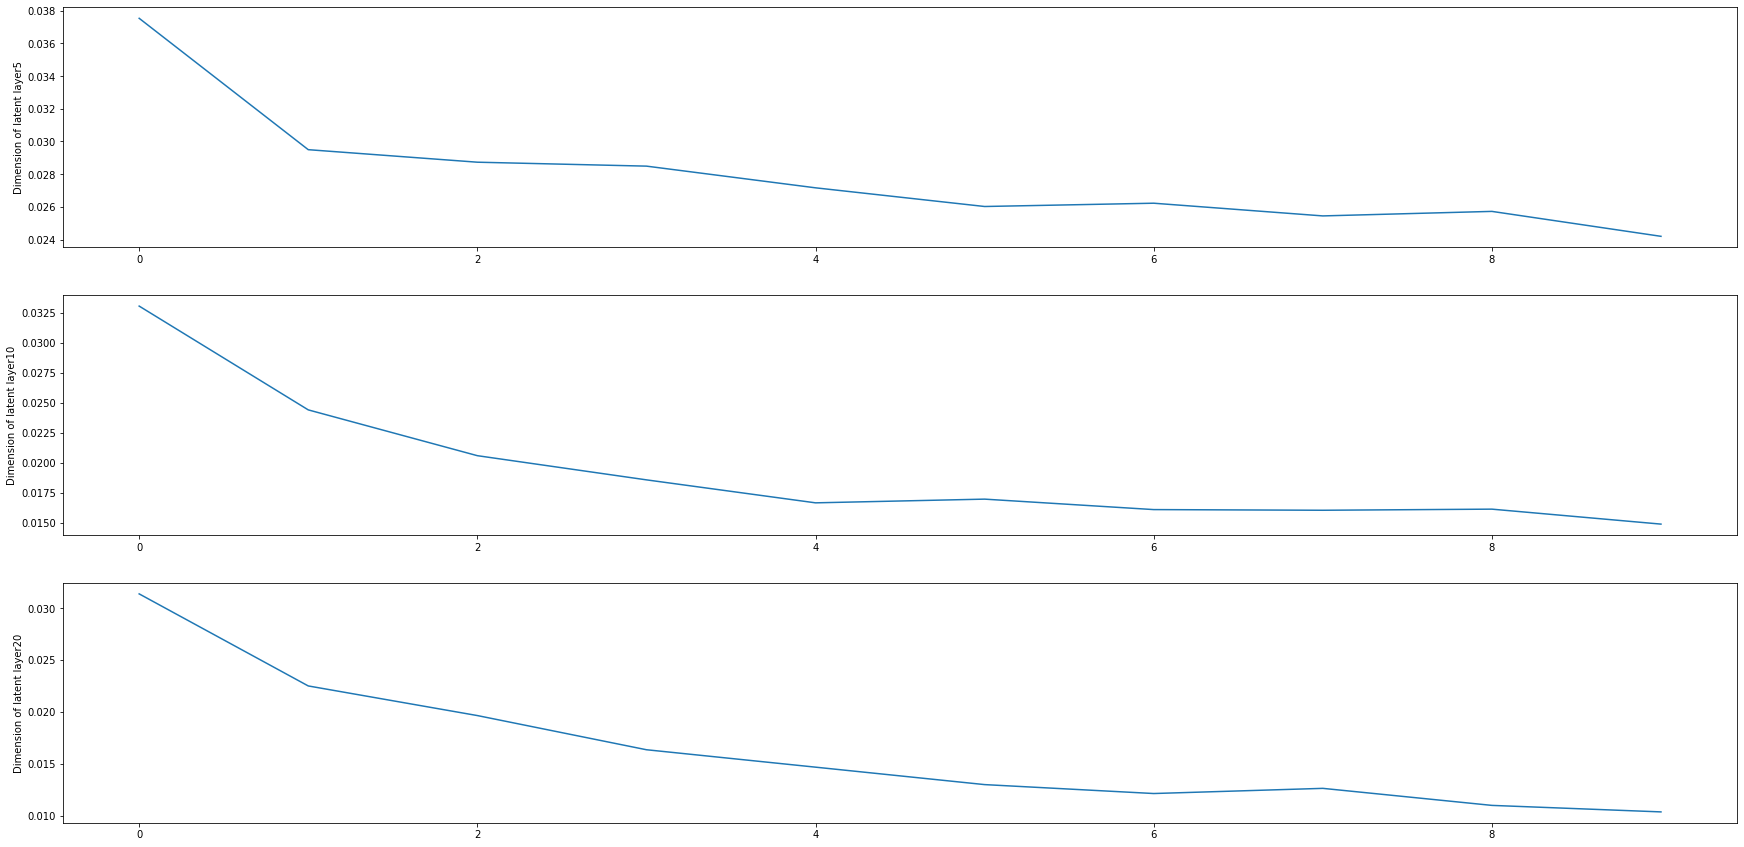

In [ ]:
from matplotlib.pyplot import figure, show

fig,axes = plt.subplots(3,1,figsize=(30,15) )
x = np.arange(0.0, 10, 1)
for i, ax in enumerate (axes):
    ax.plot(x,loss_dict[lat_arr[i]])
    ax.set_ylabel('Dimension of latent layer'+ lat_arr[i])
plt.show()

Размерность скрытоно слоя = 20

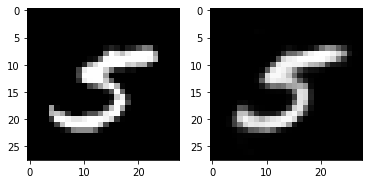

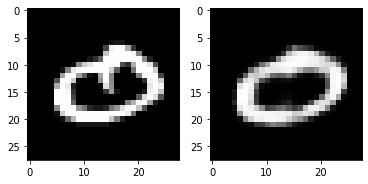

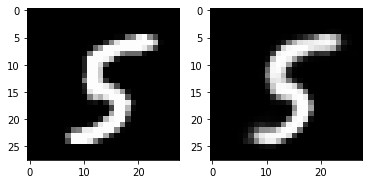

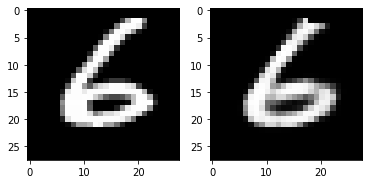

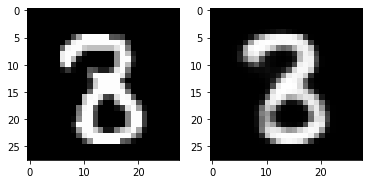

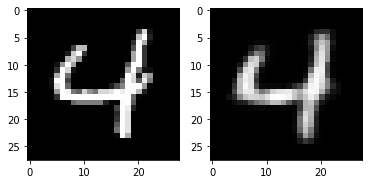

In [ ]:
loss = train(model,train_loader, loss_func, optimizer,10,device)

Размерность скрытоно слоя = 5

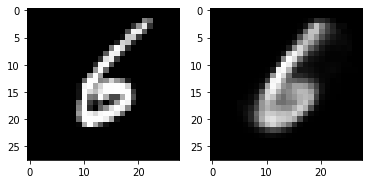

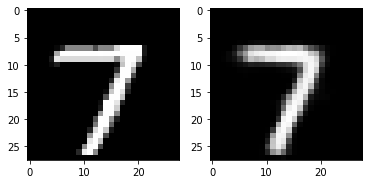

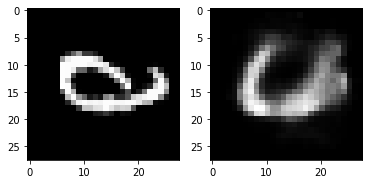

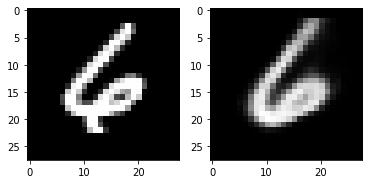

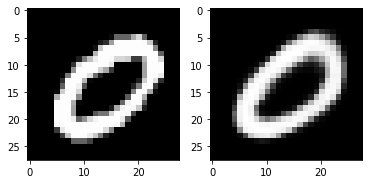

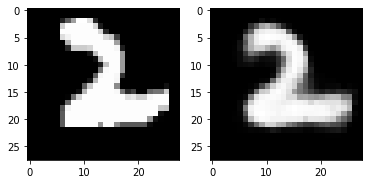

In [ ]:
loss = train(model,train_loader, loss_func, optimizer,10,device)

Размерность скрытоно слоя = 10

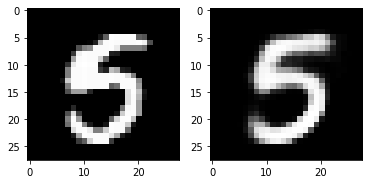

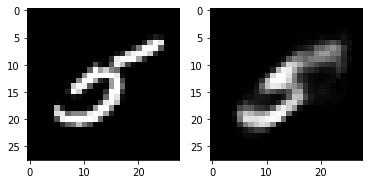

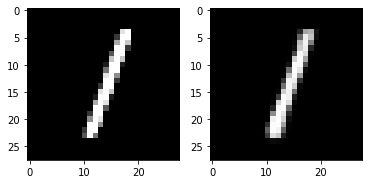

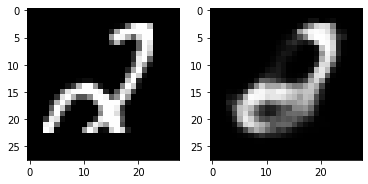

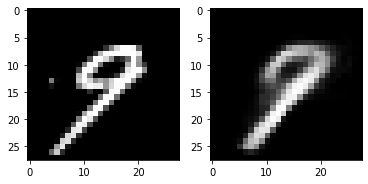

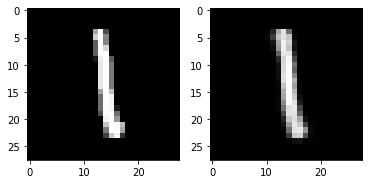

In [ ]:
loss = train(model,train_loader, loss_func, optimizer,10,device)

Как видно, что 10 компонент дейсвительно достаточно,чтобы из латентного слоя восстановить картинки.

In [11]:
def latent_labels(train_loader, model,num_objects):
    lat_codes = torch.empty((0, model.lat_dim)).to(device)
    labels = torch.empty((0)).to(device)

    for j , [image, label] in enumerate (train_loader):
        
        image, label = image.to(device), label.to(device)
        cur_lat_codes = model.encode(image)
    
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, label), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels

In [12]:
lat_dim = 10
model = Autoencoder(lat_dim).to(device)
loss = train(model,train_loader, loss_func, optimizer,10,device)

In [13]:
train_x_latent, train_y_latent = latent_labels(train_loader, model, 5000)
test_x_latent, test_y_latent = latent_labels(test_loader, model, 10000)

In [49]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500)

In [50]:
clf = clf.fit(train_x_latent,train_y_latent)

In [51]:
y_pred = clf.predict(test_x_latent)

In [52]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_y_latent , y_pred)

0.2923678

In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y_latent , y_pred)

0.9208733974358975

In [ ]:
Чтобы улучшить результаты можно добавить расширить трейн датасет, так как данный классификатор обучен на 5000 изображениях.